# 9.5 Performance Scaling for Containers and Algorithms

*Estimated time for this notebook: 15 minutes*

## 9.5.0 Python Lists vs NumPy Arrays

We've seen that NumPy arrays are really useful. Why wouldn't we always want to use them for data which is all the same type?

In [1]:
from timeit import repeat

import numpy as np
from matplotlib import pyplot as plt

Let's look at appending data to a NumPy array, compared to a plain Python list: 

In [2]:
def time_append_to_ndarray(count):
    # the function repeat does the same that the `%timeit` magic
    # but as a function; so we can plot it.
    return repeat(
        "np.append(before, [0])",
        f"import numpy as np; before=np.ndarray({count})",
        number=10000,
    )

In [3]:
help(repeat)

Help on function repeat in module timeit:

repeat(stmt='pass', setup='pass', timer=<built-in function perf_counter>, repeat=5, number=1000000, globals=None)
    Convenience function to create Timer object and call repeat method.



In [4]:
def time_append_to_list(count):
    return repeat("before.append(0)", f"before = [0] * {count}", number=10000)

In [5]:
counts = np.arange(1, 100000, 10000)


def plot_time(function, counts, title=None, top=None):
    plt.plot(counts, list(map(function, counts)))
    plt.ylim(bottom=0, top=top)
    plt.ylabel("seconds")
    plt.xlabel("array size")
    plt.title(title or function.__name__)

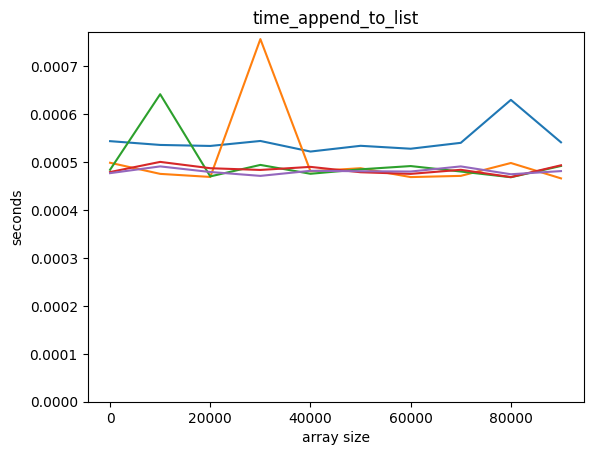

In [6]:
plot_time(time_append_to_list, counts)

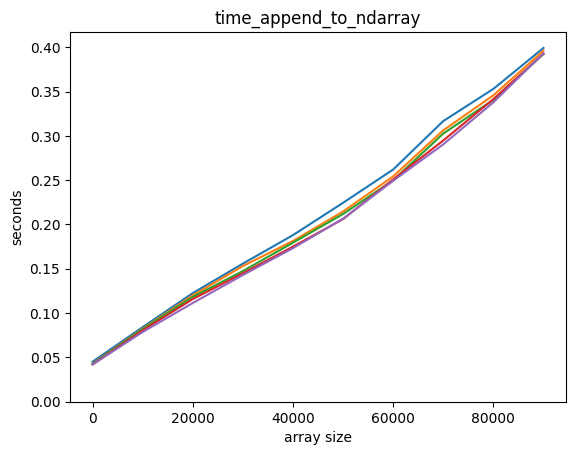

In [7]:
plot_time(time_append_to_ndarray, counts)

Adding an element to a Python list is way faster! Also, it seems that adding an element to a Python list is independent of the length of the list, but it's not so for a NumPy array.

We would say that adding an element to a Python list is "constant time". This is often written $O(1)$

We would say that adding an element to a Numpy array is "linear time". This is written $O(n)$.

If something is $O(n + 1)$ then we shorten that to $O(n)$ because the $1$ becomes negligible as $n$ grows very large.

$O()$ or "big oh" notation is also used to describe the amount of memory required to perform some operation such as sorting. 

Go to notebook **9.6 Classroom Exercises** and do *Exercise 9e*.

More on optimising with numba in notebook: **9.8 Self study**.